In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import pickle

In [2]:
# with open('model_KOA_UNet','wb') as f:
#     pickle.dump(model,f)

In [3]:
with open('model_KOA_UNet','rb') as f:
    model = pickle.load(f)

In [4]:
seed = 42
np.random.seed = seed

In [5]:
IMG_WIDTH = 128
IMG_HEIGHT= 128
IMG_CHANNELS = 3

In [6]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

In [7]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [8]:
X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH, 1), dtype=bool)

In [9]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(os.path.join(path, 'images', id_ + '.png')) 
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)  # Add channel dimension if missing
    # Resize the image
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = imread(os.path.join(path, 'masks', id_ + '.png')) 
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension if missing
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)       
    Y_train[n] = mask   

Resizing training images and masks


100%|██████████| 84/84 [00:00<00:00, 159.68it/s]


In [10]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(os.path.join(path, 'images', id_ + '.png'))
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)  # Add channel dimension if missing
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = imread(os.path.join(path, 'masks', id_ + '.png')) 
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension if missing
    sizes_test.append([mask.shape[0], mask.shape[1]])
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)       
    Y_test[n] = mask
print('Done!')

Resizing test images


100%|██████████| 5/5 [00:00<00:00, 139.26it/s]

Done!


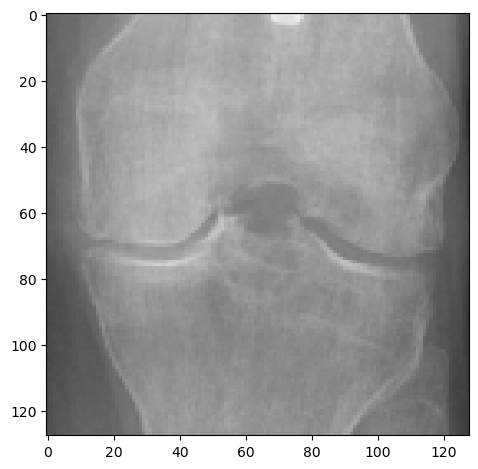

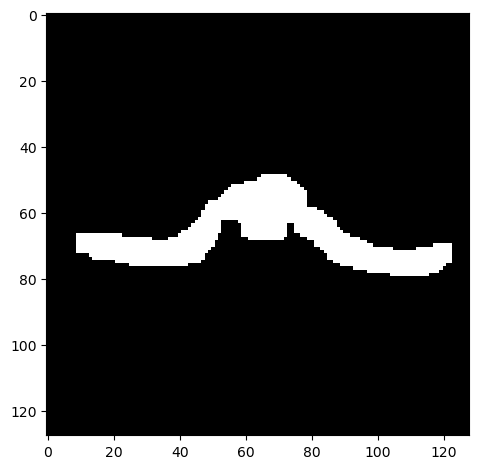

In [11]:
image_x = np.random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [12]:
# input layer

In [13]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))

In [14]:
# contraction path

In [15]:
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

In [16]:
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

In [17]:
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

In [18]:
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

In [19]:
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

In [20]:
#Expansion path

In [21]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

In [22]:
u7 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

In [23]:
u8 = tf.keras.layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

In [24]:
u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9,c1])
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

In [25]:
outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [26]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

 conv2d_15 (Conv2D)          (None, 64, 64, 32)           9248      ['dropout_7[0][0]']           
                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 16)         2064      ['conv2d_15[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 32)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 128, 128, 16)         4624      ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8

In [27]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install pydotplus

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/278.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/278.7 kB ? eta -:--:--
     - -------------------------------------- 10.2/278.7 kB ? eta -:--:--
     ----- ------------------------------- 41.0/278.7 kB 326.8 kB/s eta 0:00:01
     --------------- -------------------- 122.9/278.7 kB 798.9 kB/s eta 0:00:01
     -------------------------------------- 278.7/278.7 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24578 sha256=8118e63495cdfe504f5b63ce63488960d35589127e889a94a9594d96deff12c0
  Stored in directory: c:\users\sahil\appdata\local\pip\cache\wheels\bd\ce\e8\ff9d9c699514922f57caa22fbd55b0a32761114b4c4acc9e03
Successfully built pydotplus
Note: you may need to restart the kernel to u

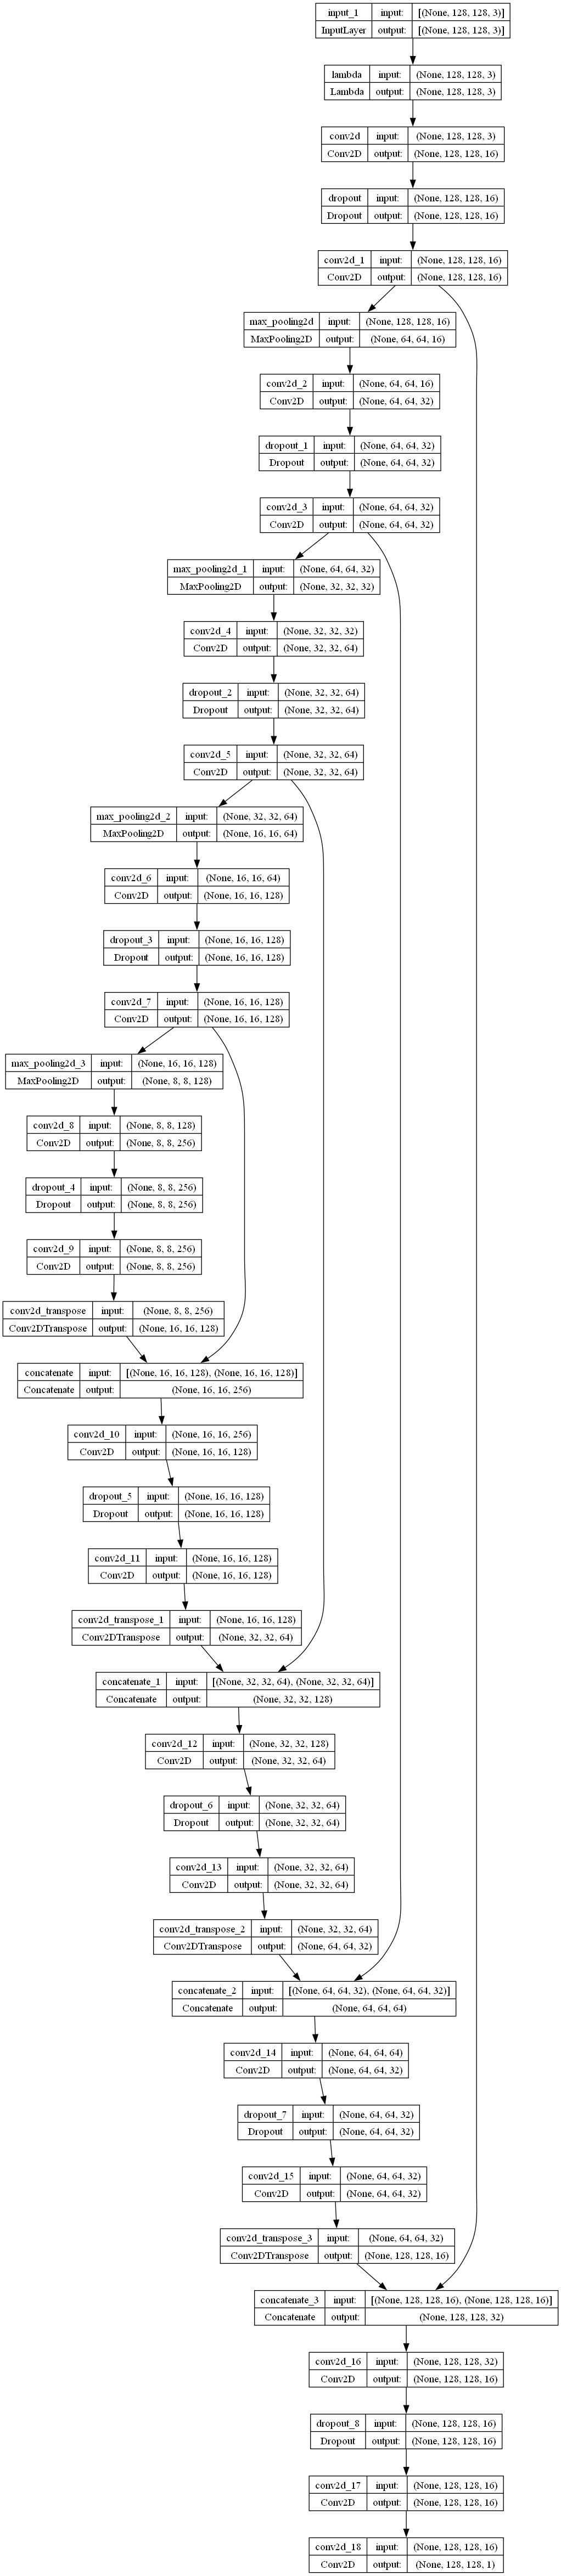

In [27]:
import pydot
import pydotplus
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

In [49]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_KOA.h4',verbose=1, save_best_only=True)
callbacks = [
                tf.keras.callbacks.TensorBoard(log_dir='logs')
            ]
results = model.fit(X_train,Y_train,batch_size=4, epochs=150, callbacks=callbacks)

Epoch 1/150
21/21 [==============================] - 14s 472ms/step - loss: 0.3946 - accuracy: 0.8954
Epoch 2/150
21/21 [==============================] - 8s 401ms/step - loss: 0.3350 - accuracy: 0.9073
Epoch 3/150
21/21 [==============================] - 9s 405ms/step - loss: 0.3270 - accuracy: 0.9073
Epoch 4/150
21/21 [==============================] - 8s 398ms/step - loss: 0.2436 - accuracy: 0.9073
Epoch 5/150
21/21 [==============================] - 9s 444ms/step - loss: 0.1783 - accuracy: 0.9073
Epoch 6/150
21/21 [==============================] - 7s 355ms/step - loss: 0.1647 - accuracy: 0.9073
Epoch 7/150
21/21 [==============================] - 8s 374ms/step - loss: 0.1518 - accuracy: 0.9073
Epoch 8/150
21/21 [==============================] - 10s 501ms/step - loss: 0.1430 - accuracy: 0.9073
Epoch 9/150
21/21 [==============================] - 9s 413ms/step - loss: 0.1373 - accuracy: 0.9076
Epoch 10/150
21/21 [==============================] - 10s 486ms/step - loss: 0.1300 - acc

In [36]:
idx = np.random.randint(0, len(X_train))
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)
preds_train_t = (preds_train > 0.99).astype(np.uint8)
preds_val_t = (preds_val > 0.99).astype(np.uint8)
preds_test_t = (preds_test > 0.99).astype(np.uint8)


1/1 [==============================] - 0s 384ms/step


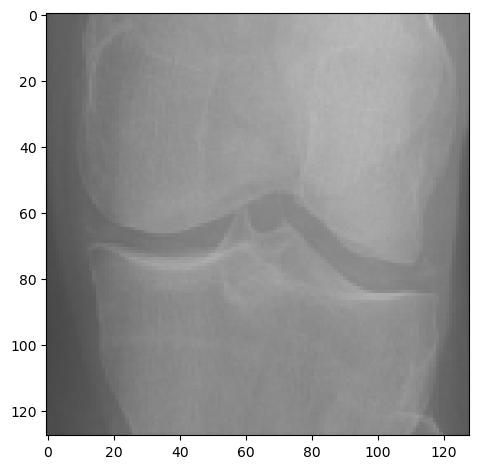

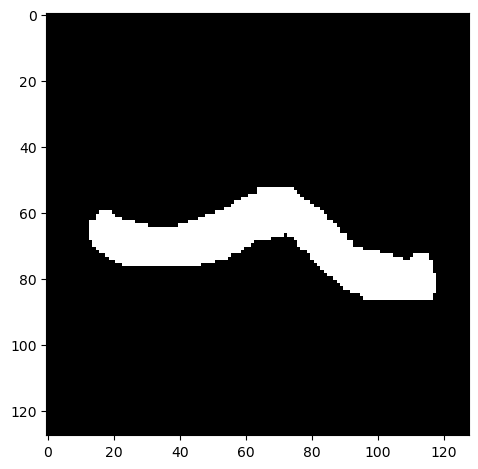

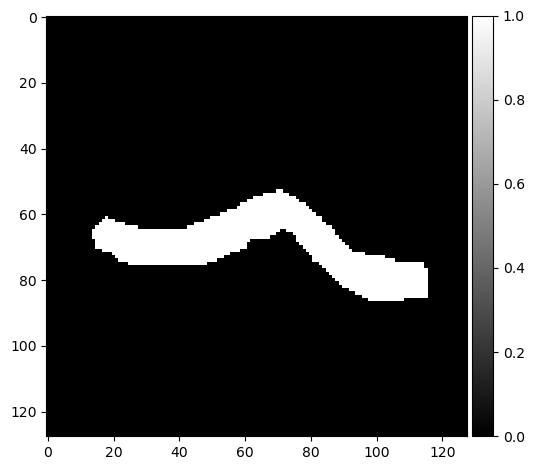

In [37]:
# Perform a sanity check on some random training samples
ix = np.random.randint(0, len(preds_train_t))
imshow(X_train[ix],cmap='gray')
plt.show()
imshow(np.squeeze(Y_train[ix]),cmap='gray')
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

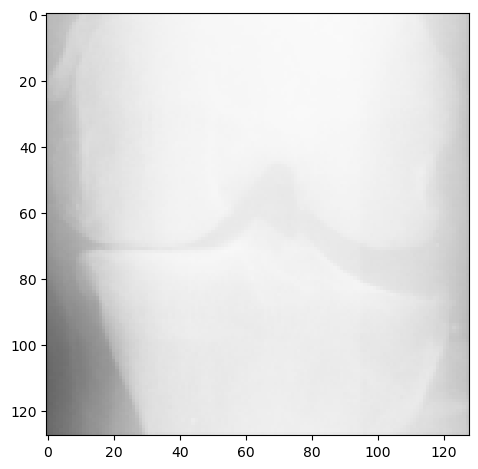

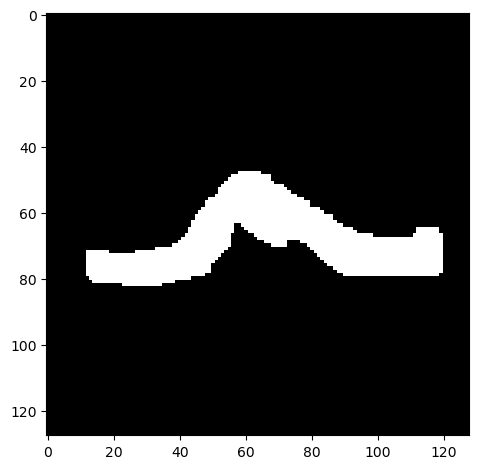

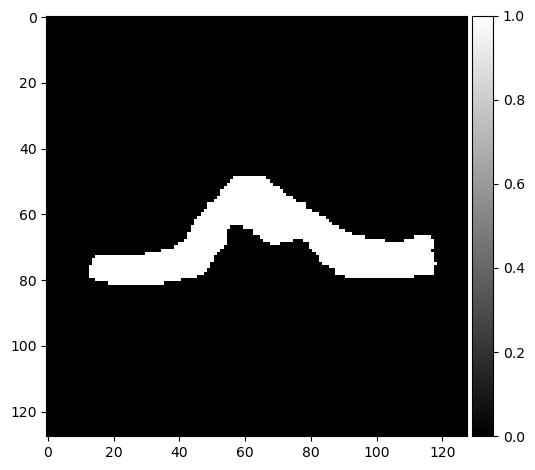

In [42]:
# Perform a sanity check on some random validation samples
ix = np.random.randint(0, len(preds_val_t))
imshow(X_train[ix],cmap='gray')
plt.show()
imshow(np.squeeze(Y_train[int(X_train.shape[0]*0.9+ix)]),cmap='gray')
plt.show()
imshow(np.squeeze(preds_val_t[ix]),cmap='gray')
plt.show()

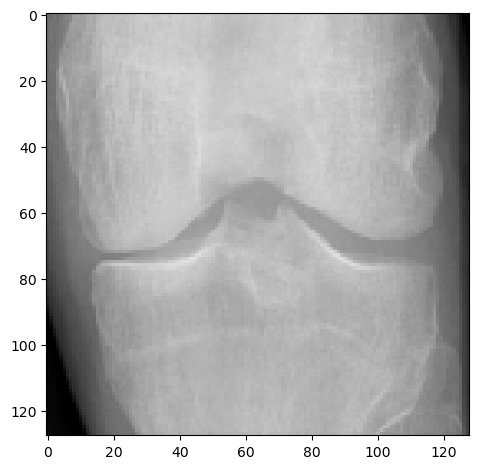

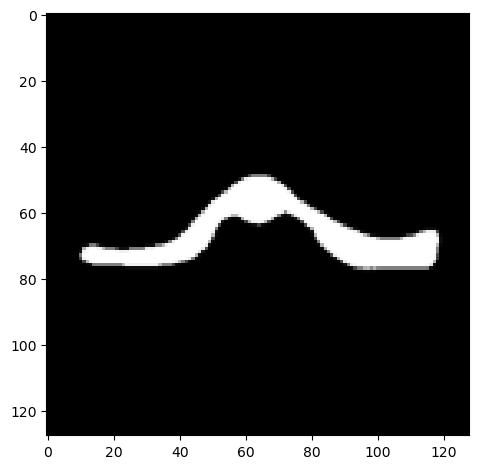

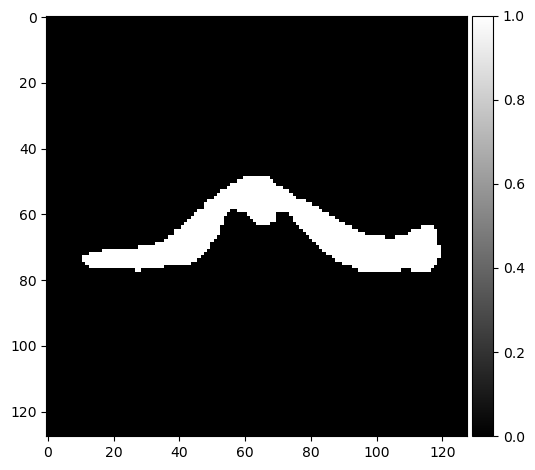

In [39]:
testix = np.random.randint(0, len(preds_test_t))
imshow(X_test[testix],cmap='gray')
plt.show()
imshow(np.squeeze(Y_test[testix]),cmap='gray')
plt.show()
imshow(np.squeeze(preds_test_t[testix]),cmap='gray')
plt.show()

In [12]:
CONVERT_PATH = 'stage2_train/Grade0/'

In [13]:
convert_files = [f for f in os.listdir(CONVERT_PATH) if os.path.isfile(os.path.join(CONVERT_PATH, f))]

In [14]:
temp_list=[]
for i in convert_files:
    i = i[:-4]
    temp_list.append(i)
convert_files=temp_list

In [15]:
ConvertToMask = np.zeros((len(convert_files),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)

In [16]:
for n, id_ in tqdm(enumerate(convert_files), total=len(convert_files)):   
    path = CONVERT_PATH
    img = imread(os.path.join(path, id_ + '.png')) 
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)  # Add channel dimension if missing
    # Resize the image
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    ConvertToMask[n] = img  #Fill empty X_train with values from img

100%|██████████| 2286/2286 [00:09<00:00, 231.93it/s]


In [17]:
conversion = model.predict(ConvertToMask, verbose=1)

72/72 [==============================] - 32s 434ms/step


In [18]:
conversion_t = (conversion > 0.9995).astype(np.uint8)

C:\ProgramData\anaconda3\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


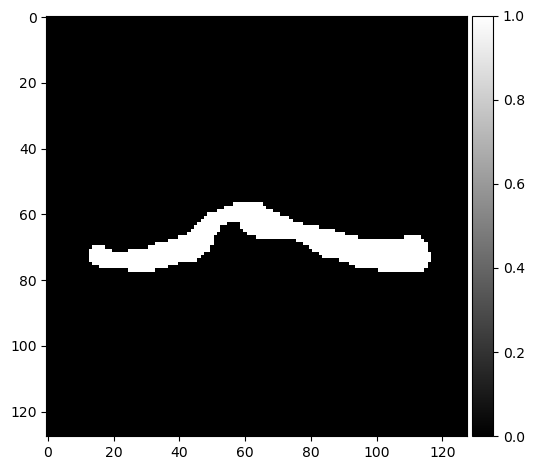

In [19]:
ix = np.random.randint(0, len(conversion_t))
imshow(conversion_t[ix],cmap='gray')
plt.show()

In [21]:
import numpy as np
import cv2
from matplotlib import cm
import time
from PIL import Image
from skimage.io import imread, imsave
from skimage.exposure import equalize_hist 
import warnings
warnings.filterwarnings('ignore')
conversion_t =[]
convert_files =[]

for i in range(0,5):
    CONVERT_PATH = 'stage2_train/Grade'+str(i)+'/'
    output_path='stage2_mask/Grade'+str(i)+'/'
    convert_files = [f for f in os.listdir(CONVERT_PATH) if os.path.isfile(os.path.join(CONVERT_PATH, f))]
    temp_list=[]
    for i in convert_files:
        i = i[:-4]
        temp_list.append(i)
        convert_files=temp_list
    ConvertToMask = np.zeros((len(convert_files),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.uint8)
    for n, id_ in tqdm(enumerate(convert_files), total=len(convert_files)):   
        path = CONVERT_PATH
        img = imread(os.path.join(path, id_ + '.png')) 
        if img.ndim == 2:
            img = np.expand_dims(img, axis=-1)
        # Resize the image
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        ConvertToMask[n] = img  
    conversion = model.predict(ConvertToMask, verbose=1)
    conversion_t = (conversion > 0.9998).astype(np.uint8)
    for k in range(len(convert_files)):
        output_filename = os.path.join(output_path, convert_files[k]+".png")
        fig = imshow(conversion_t[k])
        fig.set_cmap('gray')  
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        plt.savefig(output_filename,transparent=True,bbox_inches='tight')
        time.sleep(0.5)
        plt.close()
        
    

100%|██████████| 954/954 [00:03<00:00, 299.71it/s]


30/30 [==============================] - 12s 394ms/step


9554395L


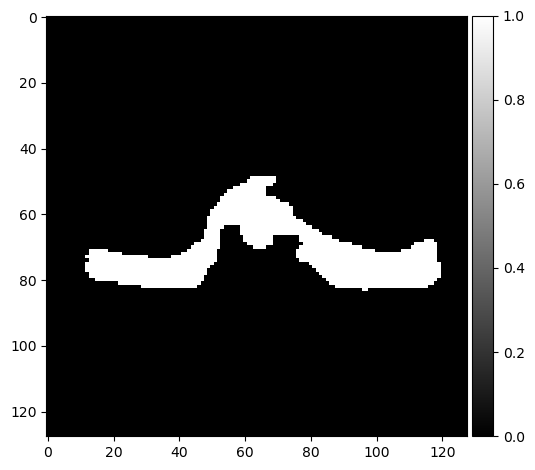

In [22]:
ix = np.random.randint(0, len(conversion_t))
print(convert_files[ix])
imshow(conversion_t[ix],cmap='gray')
plt.show()

In [23]:
import cv2
import os
from matplotlib import cm
import time
from PIL import Image
from skimage.io import imread, imsave, imshow
from skimage.exposure import equalize_hist 
import warnings
warnings.filterwarnings('ignore')
conversion_t =[]
convert_files =[]

for i in range(0,5):
    output_path='stage2_mask/Grade'+str(i)+'/'
    convert_files = [f for f in os.listdir(output_path) if os.path.isfile(os.path.join(output_path, f))]
    temp_list=[]
    for i in convert_files:
        i = i[:-4]
        temp_list.append(i)
    convert_files=temp_list
    for k in range(len(convert_files)):
        output_filename = os.path.join(output_path, convert_files[k]+".png")
        im = Image.open(output_filename)
        width, height = im.size
        left = 10
        top = 15
        right = 430
        bottom = 435
        im1 = im.crop((left, top, right, bottom))
        im1.save(output_filename)
        time.sleep(0.5)